# Run this Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P2_CartPole_REINFORCE_Baseline.ipynb)  
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P2_CartPole_REINFORCE_Baseline.ipynb)

# HW3: REINFORCE with and without baseline in CartPole
> - Full Name: **[Full Name]**
> - Student ID: **[Stundet ID]**


This notebook implements the **REINFORCE policy gradient algorithm** to train an agent in the **CartPole-v1** environment. It also compares the performance of **REINFORCE with and without a baseline** to assess its impact on training stability and efficiency.  

**Grading Breakdown:**

- Practical Implementation: 70 points
- Conceptual Understanding: 30 points

# Setup

All required packages are pre-installed if using Google Colab.


Import the following libraries.

In [27]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import gym
import matplotlib
import matplotlib.pyplot as plt
import base64
import imageio
import IPython
import logging
import warnings

# Disable warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# DEVICE
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

Configure Matplotlib for Interactive and XKCD-Style Plots

In [28]:
# Set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)

Record and Embed Simulation Videos in Jupyter Notebook

<b>embed_mp4:</b> Converts an MP4 video into a base64-encoded HTML tag for display in Jupyter Notebook.
<br>
<b>record_simulation:</b> Runs a policy in the environment, records the simulation, and saves it as an MP4 video.

In [29]:
def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

def record_simulation(env, policy_net, filename, episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(episodes):
            state = env.reset()
            frame = env.render()  # Capture the first frame
            video.append_data(frame[0])

            done = False
            while not done:
                state_tensor = torch.FloatTensor(state).to(DEVICE)
                action = torch.argmax(policy_net(state_tensor)).item()
                state, _, terminated, truncated, _ = env.step(action)

                frame = env.render()  # Capture the frame after taking the action
                video.append_data(frame[0])

                done = terminated or truncated
    return embed_mp4(filename)

# Explore the environment  (5 points)

Initialize CartPole Environment and Display State & Action Spaces

In [30]:
# Create the CartPole environment
env = gym.make("CartPole-v1")

# Print observation and action space
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action Space: Discrete(2)


**Question 1: (5 points)**

How are the observation and action spaces defined in the CartPole environment?

.....</br>
.....</br>


Define a Random Policy for Action Selection  

In [31]:
class RandomPolicy(object):
    def __init__(self, action_space_n):
        self.action_space_n = action_space_n

    def __call__(self, state):
        action_values = torch.rand(self.action_space_n)
        return action_values

Visualize the random policy.

In [32]:
random_policy = RandomPolicy(env.action_space.n)

record_simulation(gym.make("CartPole-v1", render_mode='rgb_array', new_step_api=True), random_policy, "Video_CartPole_random_policy")

# Agent with REINFORCE: Baseline vs. No Baseline in CartPole-v1 (85 points)


### Policy Network Definition (5 points)

To define a neural network that represents the agent’s policy for selecting actions.

The policy network takes the environment’s state as input and outputs a probability distribution over possible actions.

In [33]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, output_dim)

    def forward(self, state):
        x = self.fc2(self.relu(self.fc1(state)))
        return torch.log_softmax(x, dim=-1)

### Computing Discounted Returns (10 points)

To implement a function that calculates the discounted return for each timestep in an episode.

$$[
G_t = \sum_{k=0}^{T-t} \gamma^k R_{t+k}
]$$

In [34]:
def compute_returns(rewards, gamma=0.99):
    t = 1
    G = 0
    returns = []
    for r in rewards:
        G += t * r
        t *= gamma
        returns.append(G)
    return returns

**Question 2: (5 points)**

What is the role of the discount factor (𝛾) in reinforcement learning, and what happens when 𝛾=0 or 𝛾=1?

.....</br>
.....</br>


### Implementing the REINFORCE Algorithm (Without Baseline) (20 points)

To train the agent using the standard policy gradient method.
The REINFORCE algorithm updates policy parameters by using the log-probability of actions multiplied by the discounted return.

This algorithm optimizes a **stochastic policy** $( \pi_{\theta}(a_t \mid s_t) )$ by updating its parameters in the direction that increases expected rewards. The update rule is based on the **policy gradient theorem**:  

$$[
\theta \leftarrow \theta + \alpha \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) G_t
]$$

where:  

- $( \theta )$ are the policy parameters (weights of the neural network).  
- $( \alpha )$ is the learning rate.  
- $( G_t )$ is the **discounted return** from timestep $( t )$:  

- $( \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) )$ is the gradient of the log-probability of the selected action, used to adjust the policy in the correct direction.

In [52]:
def reinforce(env, policy_net, optimizer, num_episodes=1000, gamma=0.99):
    rewards_per_episode = []
    for episode in range(num_episodes):
        state = env.reset()
        trajectory, rewards = [], []

        while True:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            log_probs = policy_net(state_tensor).detach().numpy()
            probs = np.exp(log_probs)

            action = np.argmax(probs)
            new_state, reward, done, _ = env.step(action)

            trajectory.append((state, action, reward))
            rewards.append(reward)

            state = new_state

            if done:
                break

        returns = compute_returns(rewards, gamma)
        returns = torch.tensor(returns, dtype=torch.float32)

        loss = 0
        for (state, action, _), G in zip(trajectory, returns):
            state_tensor = torch.tensor(state, dtype=torch.float32)
            log_probs = policy_net(state_tensor)
            loss -= log_probs[action] * G

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        rewards_per_episode.append(sum(rewards))

        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}, Reward: {sum(rewards_per_episode)}")

    return rewards_per_episode

### Value Network Definition (Baseline Network) (5 points)

Defines a neural network that approximates the value function, which estimates the expected return from a given state. The network takes the environment’s state as input and outputs a scalar value, representing the long-term reward the agent can expect from that state.

In [53]:
class ValueNetwork(nn.Module):
    def __init__(self, input_dim):
        super(ValueNetwork, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, state):
        return self.fc2(self.relu(self.fc1(state)))

### Implementing REINFORCE with a Baseline (20 points)

To reduce variance in policy updates, we introduce a **baseline** function $( V(s) )$, which estimates the expected return from a given state. Instead of using the full return $( G_t )$, we adjust the policy update by incorporating the baseline:  

$$[
\theta \leftarrow \theta + \alpha \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) (G_t - V(s_t))
]$$

where:  

- $( \theta )$ are the policy parameters (weights of the neural network).  
- $( \alpha )$ is the learning rate.  
- $( G_t )$ is the **discounted return** from timestep $( t )$:  

  $$[
  G_t = \sum_{k=0}^{T-t} \gamma^k R_{t+k}
  ]$$

- $( V(s_t) )$ is the **baseline function**, estimated by a **value network**, which is trained using mean squared error (MSE) between predicted values and actual returns:  

  $$[
  L = \frac{1}{N} \sum_{t=0}^{N} (G_t - V(s_t))^2
  ]$$

The introduction of the baseline does not change the expected value of the gradient but significantly **reduces variance**, leading to more stable learning.  


In [54]:
def reinforce_with_baseline(env, policy_net, baseline_net, policy_optimizer, baseline_optimizer, num_episodes=1000, gamma=0.99):
    rewards_per_episode = []
    mse = nn.MSELoss()
    for episode in range(num_episodes):
        state = env.reset()
        trajectory, rewards, values = [], [], []

        while True:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            log_probs = policy_net(state_tensor).detach().numpy()
            probs = np.exp(log_probs)

            value = baseline_net(state_tensor).detach().numpy()

            action = np.argmax(probs)
            new_state, reward, done, _ = env.step(action)

            trajectory.append((state, action, reward))
            rewards.append(reward)
            values.append(value)

            state = new_state

            if done:
                break

        returns = compute_returns(rewards, gamma)
        returns = torch.tensor(returns, dtype=torch.float32)

        loss1 = 0
        loss2 = 0
        for (state, action, _), G in zip(trajectory, returns):
            state_tensor = torch.tensor(state, dtype=torch.float32)
            log_probs = policy_net(state_tensor)
            value = baseline_net(state_tensor)
            loss1 -= log_probs[action] * (G - value)
            loss2 += (G - value)**2
        loss2 /= len(values)

        policy_optimizer.zero_grad()
        loss1.backward(retain_graph=True)
        policy_optimizer.step()

        baseline_optimizer.zero_grad()
        loss2.backward()
        baseline_optimizer.step()


        rewards_per_episode.append(sum(rewards))

        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}, Reward: {sum(rewards_per_episode)}")

    return rewards_per_episode

**Question 3: (5 points)**

Why is a baseline introduced in the REINFORCE algorithm, and how does it contribute to training stability?

.....</br>
.....</br>


### Training (10 points)

To define key hyperparameters that influence training efficiency and convergence.

Hyperparameters like learning rate, discount factor, and number of episodes significantly impact the training process. Proper tuning is necessary to ensure stable learning while avoiding slow convergence or premature convergence to suboptimal policies.

In [55]:
INPUT_DIM = env.observation_space.shape[0]
OUTPUT_DIM = env.action_space.n
LEARNING_RATE = 0.01
DISCOUNT_FACTOR = 0.99
NUM_EPISODES = 500

# Initialize Policy and Baseline Networks
policy_net_no_baseline = PolicyNetwork(INPUT_DIM, OUTPUT_DIM).to(DEVICE)
policy_net_with_baseline = PolicyNetwork(INPUT_DIM, OUTPUT_DIM).to(DEVICE)
baseline_net = ValueNetwork(INPUT_DIM).to(DEVICE)

# Optimizers
policy_optimizer_no_baseline = optim.Adam(policy_net_no_baseline.parameters(), lr=LEARNING_RATE)
policy_optimizer_with_baseline = optim.Adam(policy_net_with_baseline.parameters(), lr=LEARNING_RATE)
baseline_optimizer = optim.Adam(baseline_net.parameters(), lr=LEARNING_RATE)

# Training
print("Training REINFORCE without Baseline:")
rewards_no_baseline = reinforce(env, policy_net_no_baseline, policy_optimizer_no_baseline, num_episodes=NUM_EPISODES, gamma=DISCOUNT_FACTOR)

print("\n--------------------------------------------------------------------\n")

print("Training REINFORCE with Baseline:")
rewards_with_baseline = reinforce_with_baseline(
    env, policy_net_with_baseline, baseline_net, policy_optimizer_with_baseline, baseline_optimizer,
    num_episodes=NUM_EPISODES, gamma=DISCOUNT_FACTOR
)


Training REINFORCE without Baseline:
Episode 50, Reward: 2805.0
Episode 100, Reward: 3921.0
Episode 150, Reward: 4993.0
Episode 200, Reward: 5756.0
Episode 250, Reward: 6496.0
Episode 300, Reward: 7230.0
Episode 350, Reward: 7988.0
Episode 400, Reward: 8733.0
Episode 450, Reward: 9447.0
Episode 500, Reward: 10189.0

--------------------------------------------------------------------

Training REINFORCE with Baseline:
Episode 50, Reward: 468.0
Episode 100, Reward: 942.0
Episode 150, Reward: 1419.0
Episode 200, Reward: 1894.0
Episode 250, Reward: 2366.0
Episode 300, Reward: 2826.0
Episode 350, Reward: 3294.0
Episode 400, Reward: 3771.0
Episode 450, Reward: 4236.0
Episode 500, Reward: 4705.0


**Question 4: (5 points)**

What are the primary challenges associated with policy gradient methods like REINFORCE?

.....</br>
.....</br>


# Plot and Comparing Results (10 points)

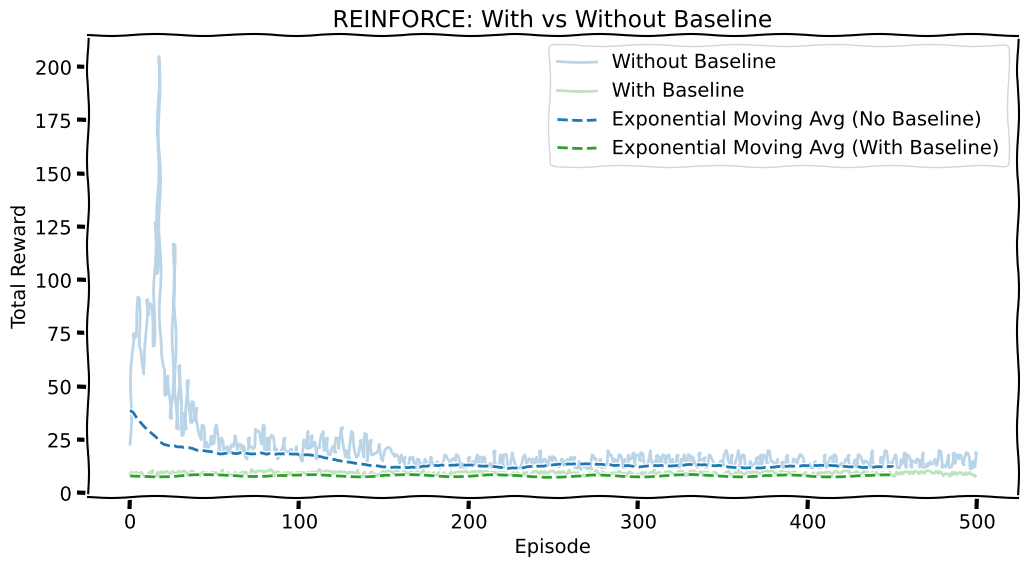

In [56]:
# Plotting Results
window_size = 50  # Moving average window size

# Exponential Moving Average calculation
def exponential_moving_average(data, window_size):
    alpha = 2 / (window_size + 1)  # Smoothing factor
    return np.convolve(data, [alpha * (1 - alpha) ** i for i in range(window_size)], mode='valid')

plt.plot(rewards_no_baseline, label="Without Baseline", alpha=0.3, color='tab:blue')
plt.plot(rewards_with_baseline, label="With Baseline", alpha=0.3, color='tab:green')

# Plotting exponential moving averages
plt.plot(exponential_moving_average(rewards_no_baseline, window_size), label="Exponential Moving Avg (No Baseline)", linestyle='--', color='tab:blue')
plt.plot(exponential_moving_average(rewards_with_baseline, window_size), label="Exponential Moving Avg (With Baseline)", linestyle='--', color='tab:green')

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("REINFORCE: With vs Without Baseline")
plt.show()

In [57]:
mean_reward, std_reward = np.mean(rewards_no_baseline), np.std(rewards_no_baseline)
print(f"No Baseline: mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

mean_reward, std_reward = np.mean(rewards_with_baseline), np.std(rewards_with_baseline)
print(f"With Baseline: mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

No Baseline: mean_reward = 20.38 +/- 16.4139
With Baseline: mean_reward = 9.41 +/- 0.6999


**Question 5:** (5 points)

Based on the results, how does REINFORCE with a baseline compare to REINFORCE without a baseline in terms of performance?

.....</br>
.....</br>


**Question 6:** (5 points)

Explain how variance affects policy gradient methods, particularly in the context of estimating gradients from sampled trajectories.

.....</br>
.....</br>

# Simulation

In [49]:
# Record the simulation using the optimal policy no baseline
record_simulation(gym.make("CartPole-v1", render_mode='rgb_array', new_step_api=True), policy_net_no_baseline, "Video_CartPole_no_baseline")

In [50]:
# Record the simulation using the optimal policy with baseline
record_simulation(gym.make("CartPole-v1", render_mode='rgb_array', new_step_api=True), policy_net_with_baseline, "Video_CartPole_with_baseline")